In [1]:
#!g1.1
%pip install sentencepiece
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Dataset size computation
import os
import json
from tqdm import tqdm
overall_len = 0
for js in tqdm(os.listdir('jsons')):
    with open("jsons/{}".format(js)) as f:
        string = f.readline()
        overall_len += len(json.loads(string))
        f.close()
overall_len

100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


4967871

In [29]:
#!g1.1
!nvidia-smi

Sun Nov 12 13:06:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:8C:00.0 Off |                  Off |
| N/A   28C    P0    24W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!g1.1
import json
from torch.utils.data import DataLoader
import sentencepiece as spm
from dataset import TinyStoriesDataset
from train import *
from model import *
import torch
import matplotlib.pyplot as plt

In [3]:
#!g1.1
%load_ext autoreload
%autoreload 2

In [4]:
#!g1.1
with open("jsons/data00.json") as f:
    string = f.readline()
d = json.loads(string)
d[0]


{'story': '\n\nLily and Ben are friends. They like to play in the park. One day, they see a big tree with a swing. Lily wants to try the swing. She runs to the tree and climbs on the swing.\n"Push me, Ben!" she says. Ben pushes her gently. Lily feels happy. She swings higher and higher. She laughs and shouts.\nBen watches Lily. He thinks she is cute. He wants to swing too. He waits for Lily to stop. But Lily does not stop. She swings faster and faster. She is having too much fun.\n"Can I swing too, Lily?" Ben asks. Lily does not hear him. She is too busy swinging. Ben feels sad. He walks away.\nLily swings so high that she loses her grip. She falls off the swing. She lands on the ground. She hurts her foot. She cries.\n"Ow, ow, ow!" she says. She looks for Ben. She wants him to help her. But Ben is not there. He is gone.\nLily feels sorry. She wishes she had shared the swing with Ben. She wishes he was there to hug her. She limps to the tree. She sees something hanging from a branch. I

In [5]:
#!g1.1
dataset_size = 100
with open("jsons/data00.json", "r") as g:
    js = json.loads(g.readline())
    with open("small_dataset", 'w+') as f:
        for i in range(dataset_size):
            f.write(js[i]["story"])

spm.SentencePieceTrainer.train(
    input="small_dataset",
    model_prefix='small_dataset',
    model_type='bpe',
    vocab_size=1000,
    normalization_rule_name='identity',
    pad_id=0, eos_id=1, bos_id=2, unk_id=3
)
tokenizer = spm.SentencePieceProcessor(model_file="small_dataset.model")


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: small_dataset
  input_format: 
  model_prefix: small_dataset
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 2
  eos_id: 1
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential_privacy_clip

In [31]:
#!g1.1
small_dataset = TinyStoriesDataset(["jsons/data00.json"], tokenizer, dataset_size=dataset_size, load_from_memory=True, filename='small_dataset_tokenized.npy')


[[  2 949   3 ...  13 189  49]
 [  2 804 153 ...   0   0   0]
 [  2 804 153 ...   0   0   0]
 ...
 [  2 804 153 ... 333 920 631]
 [  2 804 153 ...   0   0   0]
 [  2 804 153 ...   0   0   0]]


In [32]:
#!g1.1
small_dataset.corpus

array([[  2, 949,   3, ...,  13, 189,  49],
       [  2, 804, 153, ...,   0,   0,   0],
       [  2, 804, 153, ...,   0,   0,   0],
       ...,
       [  2, 804, 153, ..., 333, 920, 631],
       [  2, 804, 153, ...,   0,   0,   0],
       [  2, 804, 153, ...,   0,   0,   0]])

In [ ]:
#!g1.1
import torch
import numpy as np
from tqdm import tqdm
# l = ["Lily and Ben are friends.", "They like to play in the park"]
# seqs = [torch.tensor(tokenizer.encode(x, add_eos=True, add_bos=True), dtype=torch.int) for x in l]
# seqs
ls = []
s = []
for i in tqdm(range(len(small_dataset))):
    ls.append(len(tokenizer.encode(small_dataset[i], add_eos=True, add_bos=True)))
    s.append(len(small_dataset[i]))

In [37]:
#!g1.1
device = torch.device("cuda:0")

In [33]:
#!g1.1
decoder = BoutiqueLM(
    vocab_stories_size=1000,
    num_layers=1,
    num_heads=8,
    hidden_dim=128,
    activation=nn.GELU,
    max_len=10000
)#.to(device)

In [34]:
#!g1.1
sum(p.numel() for p in decoder.parameters())

453760

In [35]:
#!g1.1
num_workers = 2
lr = 1.25e-3
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=150, pct_start=0.3, final_div_factor=10,)
train_loader = DataLoader(
    small_dataset,
    batch_size=100,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    small_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers
)

In [42]:
#!g1.1
wandb.login(key="9f8480fbfcfd1d06b91b59aa5d23ed5482fdee2e", relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [44]:
#!g1.1
wandb.init(project="DL bhw-1",
          entity="kilka74",
          name="overfit small data, decoder-only",
          config={
              "batch_size":512,
              "seq_len":256,
              "embed_dim":512,
              "num_heads":8,
              "num_layers":1,
              "tokenizetion":"BPE",
              "vocab_size":10000,
              "lr": 5e-4
          })

wandb: Currently logged in as: kilka74. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20231112_131720-k308ka9a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run overfit small data, decoder-only
wandb: ⭐️ View project at https://wandb.ai/kilka74/DL%20bhw-1
wandb: 🚀 View run at https://wandb.ai/kilka74/DL%20bhw-1/runs/k308ka9a


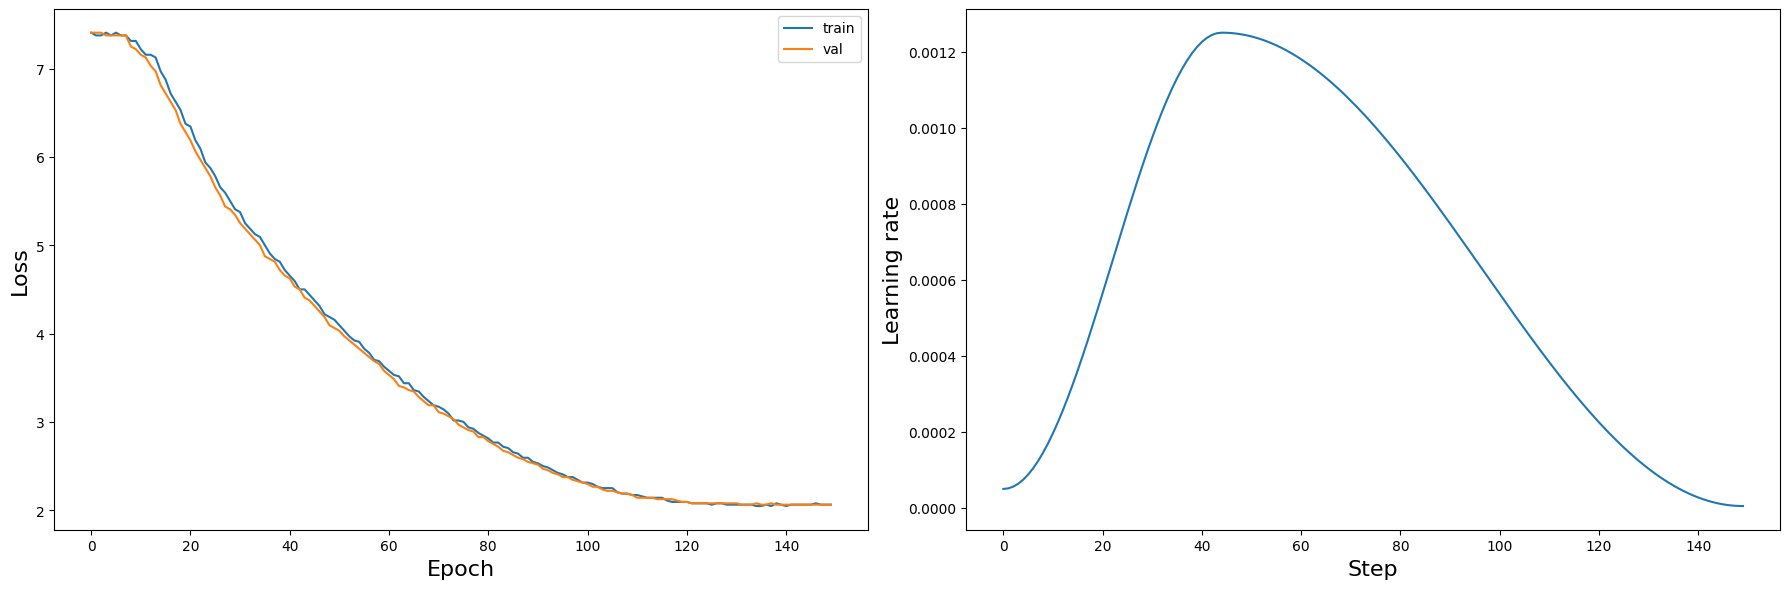

In [36]:
#!g1.1
train(
    model=decoder,
    num_epochs=150,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    # wandb_log=True,
    # device=torch.device("cuda:0")
)

In [47]:
#!g1.1
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         lr ▁▁▁▁▁
wandb: train_loss █▅▄▂▁
wandb:   val_loss █▇▄▂▁
wandb: 
wandb: Run summary:
wandb:         lr 0.0005
wandb: train_loss 3.12163
wandb:   val_loss 3.03119
wandb: 
wandb: 🚀 View run overfit small data, decoder-only at: https://wandb.ai/kilka74/DL%20bhw-1/runs/k308ka9a
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231112_131720-k308ka9a/logs


In [12]:
#!g1.1
def _save_checkpoint(model, optimizer, epoch, save_best=False, only_best=False):
        """
        Saving checkpoints

        :param epoch: current epoch number
        :param save_best: if True, rename the saved checkpoint to 'model_best.pth'
        """
        arch = type(model).__name__
        state = {
            "arch": arch,
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        filename = str("checkpoint-epoch{}.pth".format(epoch))
        if not (only_best and save_best):
            torch.save(state, filename)
#             logger.info("Saving checkpoint: {} ...".format(filename))
        if save_best:
            best_path = str("model_best.pth")
            torch.save(state, best_path)
#             logger.info("Saving current best: model_best.pth ...")

In [13]:
#!g1.1
_save_checkpoint(decoder, optimizer, 150)

In [14]:
#!g1.1
tokenizer = spm.SentencePieceProcessor(model_file="small_dataset.model")
d = torch.load('checkpoint-epoch150.pth', map_location=torch.device('cpu'))

In [15]:
d['state_dict']

OrderedDict([('embeds.weight',
              tensor([[ 1.2188,  0.2656,  0.4336,  ..., -1.0312, -0.7617, -0.3398],
                      [-0.6172, -1.5469,  0.8867,  ..., -1.3750,  0.2227, -0.8320],
                      [-0.5078,  1.3047,  1.4688,  ..., -0.3262, -0.1406,  1.0547],
                      ...,
                      [ 0.2236,  0.5000,  2.5938,  ...,  0.0532,  0.5312,  1.1953],
                      [-1.3750,  2.2344,  1.0391,  ...,  1.0469,  1.6484, -0.5430],
                      [-0.4277, -0.5469,  0.6836,  ...,  0.0869, -0.8477,  0.0469]],
                     dtype=torch.bfloat16)),
             ('positional_encoding.sin',
              tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
                         0.0000e+00,  0.0000e+00],
                       [ 8.3984e-01,  7.6172e-01,  6.7969e-01,  ...,  1.5831e-04,
                         1.4019e-04,  1.1587e-04],
                       [ 9.1016e-01,  9.8828e-01,  9.9609e-01,  ...,  3.1662e-04,
   

In [16]:
model = BoutiqueLM(
    vocab_stories_size=1000,
    num_layers=1,
    num_heads=8,
    hidden_dim=128,
    activation=nn.GELU,
    max_len=10000
)

model.load_state_dict(d['state_dict'])

<All keys matched successfully>

In [19]:
s = "Bob ran to his friend, a bird named Sue. Bob said, \"Sue, I saw a hunter in the"
s

'Bob ran to his friend, a bird named Sue. Bob said, "Sue, I saw a hunter in the'

In [21]:
generate_story(model=model, tokenizer=tokenizer, beginning="Bob and Sue hid in a small hole. The hunter came near, but he did not see them.", story_length=30)

'Bob and Sue hid in a small hole. The hunter came near, but he did not see them. a new things. They were playing. The ball near, a big unknown animal was scared. They were happy. They were playing in the man'